# Task 1: MNIST with Optimal Learning Rate & TensorBoard

## Step 1: MNIST Optimization

**Objective:** Reach >98% accuracy on the MNIST dataset.

### Learning Rate Finder

We implement a callback that exponentially increases the learning rate during training. By plotting Loss vs. Learning Rate, we can identify the optimal learning rate range—typically 10x smaller than the rate where the loss begins to increase.

### TensorBoard Integration

TensorBoard provides real-time visualization of training metrics including:
- Loss curves
- Accuracy metrics
- Learning rate progression
- Model graph structure

### Step 1: Data Loading and Preprocessing

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Load MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# 2. Scale pixel values to [0, 1] range
# Neural networks perform better with small, normalized input values
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# 3. Create a validation set (last 5,000 images)
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(f"Data Loaded: {len(X_train)} training samples, {len(X_valid)} validation samples")

2026-02-20 13:33:12.972902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loaded: 55000 training samples, 5000 validation samples


### Step 2: Define the Learning Rate Finder Callback

In [3]:
# Custom callback to grow learning rate exponentially during training
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        super().__init__() # Ensure parent class is initialized
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        # 1. Access the learning rate variable directly from the optimizer
        lr_variable = self.model.optimizer.learning_rate

        # 2. Convert to float safely (Works across Keras 2 and 3)
        current_lr = float(lr_variable)

        self.rates.append(current_lr)
        self.losses.append(logs["loss"])

        # 3. Use .assign() to update the learning rate for the next batch
        # This is the modern, safe way to change variables in Keras/TensorFlow
        lr_variable.assign(current_lr * self.factor)

### Step 3: Find the Optimal Learning Rate

/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5956 - loss: nan


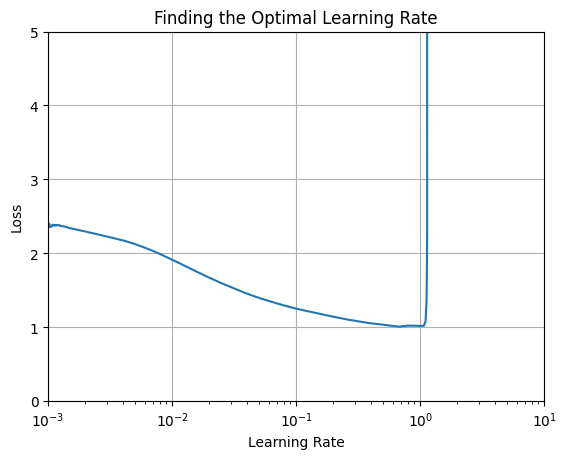

In [4]:
# 1. Build a basic MLP model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# 2. Compile with a low starting LR
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

# 3. Run the LR finder for 1 epoch
expon_lr = ExponentialLearningRate(factor=1.005)
model.fit(X_train, y_train, epochs=1, callbacks=[expon_lr])

# 4. Plot the results
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.axis([1e-3, 10, 0, 5])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding the Optimal Learning Rate")
plt.grid(True)
plt.show()

### Step 4: Final Training with TensorBoard and Precision MetricNote: Look at your plot above. Usually, a good choice is about 1/10th of the rate where the loss started to explode. For MNIST, this is often around $3 \times 10^{-1}$.

### One-Hot Encoding

In deep learning laboratory settings, labels are typically transformed using **One-Hot Encoding**. This converts a single numeric label (e.g., class `5`) into a binary vector:


In [5]:

# 1. One-Hot Encode the labels to fix the Precision metric shape error
# This turns integers (0-9) into 10-element vectors
y_train_cat = keras.utils.to_categorical(y_train, num_classes=10)
y_valid_cat = keras.utils.to_categorical(y_valid, num_classes=10)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=10)

# 2. Define TensorBoard log directory
root_logdir = os.path.join(os.curdir, "my_mnist_logs")
tensorboard_cb = keras.callbacks.TensorBoard(root_logdir)

# 3. Re-build/Reset the model
model = keras.models.clone_model(model)

# 4. Compile with Categorical Crossentropy and standard Precision
model.compile(
    loss="categorical_crossentropy", # Changed from sparse because of one-hot labels
    optimizer=keras.optimizers.SGD(learning_rate=3e-1),
    metrics=["accuracy", keras.metrics.Precision(name="precision")]
)

# 5. Final Training
# We use the categorical labels here
history = model.fit(X_train, y_train_cat, epochs=20,
                    validation_data=(X_valid, y_valid_cat),
                    callbacks=[tensorboard_cb])

# 6. Evaluate on Test Set
test_results = model.evaluate(X_test, y_test_cat)
print(f"\nFinal Test Accuracy: {test_results[1]:.4f}")
print(f"Final Test Precision: {test_results[2]:.4f}")

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9279 - loss: 0.2338 - precision: 0.9484 - val_accuracy: 0.9720 - val_loss: 0.0942 - val_precision: 0.9776
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9717 - loss: 0.0926 - precision: 0.9760 - val_accuracy: 0.9734 - val_loss: 0.0882 - val_precision: 0.9784
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9794 - loss: 0.0641 - precision: 0.9824 - val_accuracy: 0.9772 - val_loss: 0.0780 - val_precision: 0.9807
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9840 - loss: 0.0481 - precision: 0.9856 - val_accuracy: 0.9762 - val_loss: 0.0861 - val_precision: 0.9781
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9888 - loss: 0.0350 - precision: 0.9897 - val_accuracy: 0.9822 - val_loss: 0.0724 - val_precision: 0.9837
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9911 - loss: 0.0282 - precision: 0.9920 - val_accuracy: 0.

# Task 2: The 100-Layer Challenge & Vanishing Gradients

## Step 2: Deep Architecture Analysis

**Objective:** Understanding why modern architectures need specialized activation functions.

### Vanishing Gradients

In very deep networks, gradients diminish as they propagate backward through layers. By the time the gradient signal reaches the initial layers, it approaches zero—effectively stopping the model from learning in early layers.

#### 1. The "Vanishing Gradient" Trap (Sigmoid)
If you train the 100-layer model with Sigmoid, you will likely see the accuracy stay stuck at exactly 10%.

Why: In a 100-layer network, the "signal" from the error at the end of the model gets smaller and smaller as it travels backward toward the first layer.

The Result: By the time the math reaches the early layers, the update value is so tiny (vanishing) that the weights never change. The model stays in a state of "random guessing," and since there are 10 classes in MNIST, a random guess is 10% accurate.

#### 2. The "Self-Normalizing" Miracle (SELU)
If you switch to SELU (Scaled Exponential Linear Unit), the model should actually start learning.

Why: SELU, when paired with kernel_initializer="lecun_normal", has a special mathematical property: it keeps the mean and variance of the neuron outputs consistent across all 100 layers.

The Result: The gradient doesn't explode or vanish, allowing the information to flow through all 100 layers. You will see the accuracy climb from 10% to 90%+.

### Activation Function Comparison

| Activation | Characteristics | Vanishing Gradient Issue |
|------------|-----------------|--------------------------|
| **Sigmoid** | Saturates at 0 or 1 | Severe - gradients vanish due to saturation |
| **ReLU** | Positive values pass, negatives become 0 | Moderate - can cause "Dying ReLU" where neurons get stuck at 0 |
| **ELU/SELU** | Allows negative values, keeps mean activation near zero | Minimal - SELU provides "Self-Normalization" for deep networks |

In [9]:
# Function to build a super deep 100-layer model
def build_deep_model(activation):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    # Add 100 hidden layers
    for _ in range(100):
        model.add(keras.layers.Dense(100, activation=activation, kernel_initializer="he_normal" if activation != "sigmoid" else "glorot_uniform"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

# Practice: Run this for 'sigmoid' then 'selu'
# Note: Sigmoid will likely show 10% accuracy (random guessing) because it can't train 100 layers.
# model_deep = build_deep_model("selu")
model_deep = build_deep_model("sigmoid")
model_deep.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# --- TEST 1: SIGMOID ---
print("Training 100-layer model with SIGMOID...")
model_sigmoid = build_deep_model("sigmoid")
model_sigmoid.compile(loss="sparse_categorical_crossentropy",
                      optimizer="nadam",
                      metrics=["accuracy"])

# Pass the actual data variables here!
model_sigmoid.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))


# --- TEST 2: SELU ---
print("\nTraining 100-layer model with SELU...")
model_selu = build_deep_model("selu")
model_selu.compile(loss="sparse_categorical_crossentropy",
                   optimizer="nadam",
                   metrics=["accuracy"])

# Pass the actual data variables here!
model_selu.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Training 100-layer model with SIGMOID...
Epoch 1/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 67s 18ms/step - accuracy: 0.1028 - loss: 2.3100 - val_accuracy: 0.0988 - val_loss: 2.3124
Epoch 2/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.1022 - loss: 2.3077 - val_accuracy: 0.0964 - val_loss: 2.3040
Epoch 3/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.1063 - loss: 2.3057 - val_accuracy: 0.0966 - val_loss: 2.3054
Epoch 4/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.1093 - loss: 2.3028 - val_accuracy: 0.1060 - val_loss: 2.3026
Epoch 5/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.1123 - loss: 2.3016 - val_accuracy: 0.1060 - val_loss: 2.3020
Epoch 6/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.1129 - loss: 2.3014 - val_accuracy: 0.1060 - val_loss: 2.3019
Epoch 7/15
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.1129 - loss: 2.3013 - val_accuracy: 0.1060 - val_loss: 2.3027
Epoch 8/15
1719/1719 ━━━━━━━━━━━━━━

# Task 3: CIFAR10, Batch Normalization, and Optimizers

## Step 3: CIFAR10 and Optimization

**Objective:** Train on the more complex CIFAR10 dataset (color images, 3 channels) and address training stability issues.

### He Initialization

Designed specifically for ELU/ReLU activation functions to prevent signal death and maintain proper gradient flow throughout the network.

### Batch Normalization (BN)

Standardizes the inputs to each layer, providing:
- Ability to use much higher learning rates
- Reduced sensitivity to weight initialization
- Faster convergence and improved training stability

### Optimizer Comparison

| Optimizer | Description | Best Use Case |
|-----------|-------------|---------------|
| **Momentum** | Builds velocity like a ball rolling downhill | Standard SGD with faster convergence |
| **Adam/Nadam** | Combines momentum with adaptive learning rates per weight | The "go-to" optimizer for most deep learning tasks |

In [11]:
# 1. Load CIFAR10
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_full = X_train_full / 255.0

# 2. Build DNN with Batch Normalization
model_cifar = keras.Sequential()
model_cifar.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Add 20 layers with Batch Normalization
for _ in range(20):
    model_cifar.add(keras.layers.Dense(100, kernel_initializer="he_normal")) # Layer
    model_cifar.add(keras.layers.BatchNormalization())                      # Normalization
    model_cifar.add(keras.layers.Activation("elu"))                        # Activation

model_cifar.add(keras.layers.Dense(10, activation="softmax"))

# 3. Train with Nadam
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model_cifar.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Early Stopping to save time
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_cifar = model_cifar.fit(X_train_full, y_train_full, epochs=50,
                                validation_split=0.1, callbacks=[early_stopping_cb])

Epoch 1/50


2026-02-14 17:10:58.480078: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 552960000 exceeds 10% of free system memory.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 29ms/step - accuracy: 0.3379 - loss: 1.8422 - val_accuracy: 0.3714 - val_loss: 1.7833
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.4056 - loss: 1.6603 - val_accuracy: 0.3618 - val_loss: 1.7728
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.4335 - loss: 1.5919 - val_accuracy: 0.4034 - val_loss: 1.7095
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.4541 - loss: 1.5405 - val_accuracy: 0.4368 - val_loss: 1.5845
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.4690 - loss: 1.5067 - val_accuracy: 0.4168 - val_loss: 1.6746
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 63s 23ms/step - accuracy: 0.4807 - loss: 1.4671 - val_accuracy: 0.4252 - val_loss: 1.6027
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.4925 - loss: 1.4353 - val_accuracy: 0.4770 - val_loss: 1.4744
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.5015 - loss: 1.40

## Comparison Discussion

### Convergence Speed
Batch Normalization typically enables the model to reach higher accuracy in fewer epochs, even though each epoch may take slightly longer to compute due to the additional normalization calculations.

### Optimizer Differences

| Optimizer | Characteristics | Tuning Required |
|-----------|-----------------|------------------|
| **SGD** | Slow convergence, can get stuck in local minima | High |
| **Momentum/NAG** | Faster than SGD, builds velocity, better at escaping local minima | Medium |
| **Adam/Nadam** | Most "forgiving", combines momentum with adaptive learning rates, fastest convergence | Low |